
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\HP\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\HP\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\HP\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\HP\anaconda3\lib\site-packages\ipykernel\

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\HP\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\HP\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\HP\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\HP\anaconda3\lib\site-packages\ipykernel\

AttributeError: _ARRAY_API not found

Rows after cleaning: 401
Age groups: ['<= 65 years', '> 65 years']
Phenotypes: {0: 269, 1: 132}
Saved tables:
 - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\bmi_value_summary_tidy.csv
 - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\bmi_value_summary_wide.csv


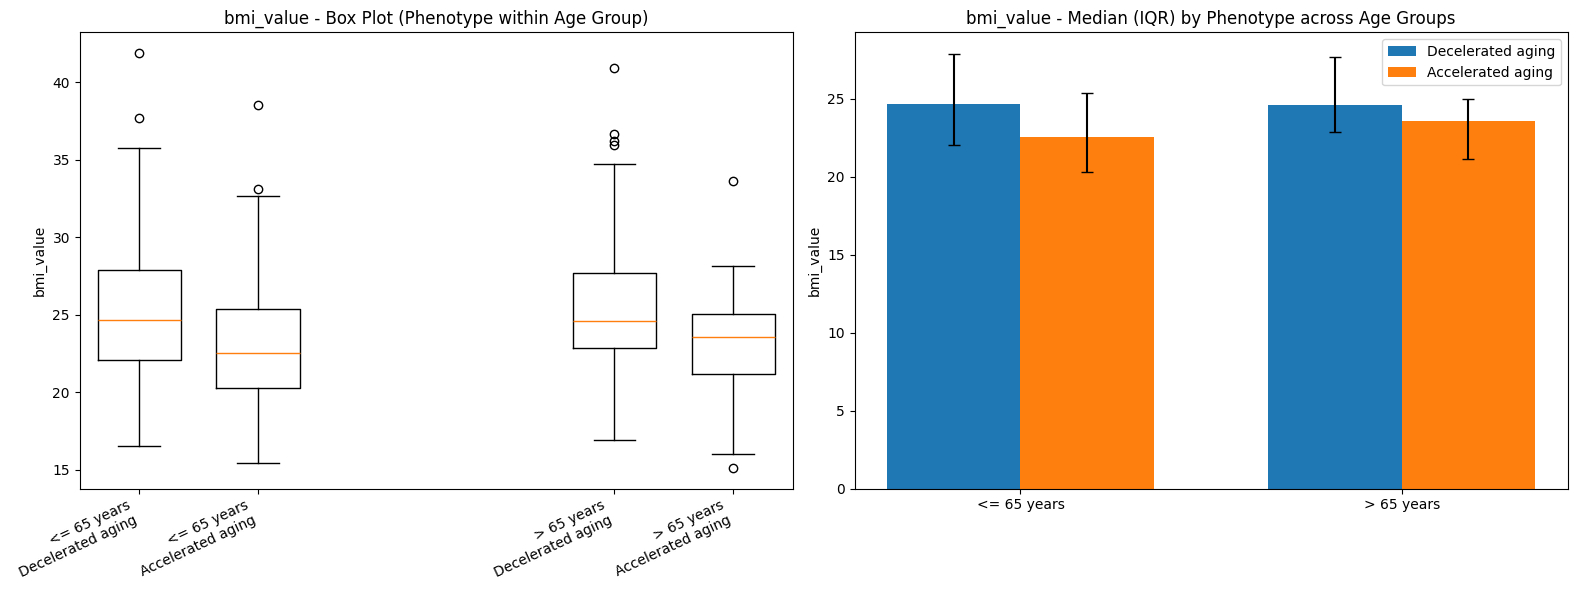

Saved figure:
 - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\bmi_value_agegroup_x_phenotype_1x2.png


In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) Paths (EDIT)
# ----------------------------
DATA_PATH = r"C:\Users\HP\OneDrive\Desktop\Phase 3\merged_with_phenotypes\master_with_phenotype.csv"
OUT_DIR   = r"C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype"

os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# 1) Helpers
# ----------------------------
def is_missing_like(x) -> bool:
    if pd.isna(x):
        return True
    s = str(x).strip().lower()
    if s in ["", "na", "n/a", "none", "null", "missing", "unknown", "missing/unknown", "not known", "not available"]:
        return True
    if ("missing" in s) or ("unknown" in s):
        return True
    return False

def to_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series, errors="coerce")

def safe_name(s: str) -> str:
    s = str(s).strip()
    s = re.sub(r"[<>:\"/\\|?*]", "_", s)  # windows invalid
    s = re.sub(r"\s+", "_", s)
    return s

# ----------------------------
# 2) Load + clean core fields
# ----------------------------
df = pd.read_csv(DATA_PATH)
df.columns = [str(c).strip() for c in df.columns]

required = ["phenotype", "age_group"]
for c in required:
    if c not in df.columns:
        raise ValueError(f"Missing required column '{c}'. Columns: {df.columns.tolist()}")

# Pick BMI numeric column
BMI_CANDIDATES = ["bmi_value", "bmi", "BMI", "BMI_value", "bmi_val"]
bmi_col = next((c for c in BMI_CANDIDATES if c in df.columns), None)
if bmi_col is None:
    raise ValueError(f"No BMI numeric column found. Tried: {BMI_CANDIDATES}")

# Clean age_group (remove Missing/Unknown)
df["age_group_clean"] = df["age_group"].astype(str).str.strip()
df = df[~df["age_group_clean"].apply(is_missing_like)].copy()

# Keep the two intended groups only (adjust if your labels differ)
age_order = ["<= 65 years", "> 65 years"]
df = df[df["age_group_clean"].isin(age_order)].copy()

# Clean phenotype
df["phenotype"] = pd.to_numeric(df["phenotype"], errors="coerce")
df = df[df["phenotype"].isin([0, 1])].copy()

# Clean BMI numeric
df[bmi_col] = to_numeric(df[bmi_col])
df = df[df[bmi_col].notna()].copy()

print("Rows after cleaning:", len(df))
print("Age groups:", sorted(df["age_group_clean"].unique().tolist()))
print("Phenotypes:", df["phenotype"].value_counts().to_dict())

# Labels
PHENO_LABEL = {0: "Decelerated aging", 1: "Accelerated aging"}

# ----------------------------
# 3) Summary table (stratified by age_group x phenotype)
# ----------------------------
summary = (
    df
    .groupby(["age_group_clean", "phenotype"])[bmi_col]
    .agg(
        N="count",
        mean="mean",
        sd="std",
        median="median",
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75),
        min="min",
        max="max"
    )
    .reset_index()
)

summary["phenotype_label"] = summary["phenotype"].map(PHENO_LABEL)

# Save tidy + wide versions
summary_tidy_path = os.path.join(OUT_DIR, f"{safe_name(bmi_col)}_summary_tidy.csv")
summary.to_csv(summary_tidy_path, index=False)

summary_wide = summary.pivot(index="age_group_clean", columns="phenotype_label", values=["N","median","q1","q3","mean","sd"])
summary_wide.columns = [f"{a}_{b}" for a,b in summary_wide.columns]
summary_wide = summary_wide.reset_index()

summary_wide_path = os.path.join(OUT_DIR, f"{safe_name(bmi_col)}_summary_wide.csv")
summary_wide.to_csv(summary_wide_path, index=False)

print("Saved tables:")
print(" -", summary_tidy_path)
print(" -", summary_wide_path)

# ----------------------------
# 4) 1x2 Figure:
#     Left = boxplot (BMI by phenotype within each age_group)
#     Right = bar plot (median BMI by phenotype within each age_group) + IQR error bars
# ----------------------------
# Prepare boxplot data in explicit order:
# For each age group, show phenotype 0 then phenotype 1
box_data = []
box_labels = []
positions = []

pos = 1
gap_within = 1.0      # spacing between phenotypes in same age group
gap_between = 2.0     # spacing between age groups

for ag in age_order:
    for ph in [0, 1]:
        s = df[(df["age_group_clean"] == ag) & (df["phenotype"] == ph)][bmi_col].dropna().values
        box_data.append(s)
        box_labels.append(f"{ag}\n{PHENO_LABEL[ph]}")
        positions.append(pos)
        pos += gap_within
    pos += gap_between  # extra gap after each age group

# Bar plot data (median with IQR)
bar_rows = []
for ag in age_order:
    for ph in [0, 1]:
        s = df[(df["age_group_clean"] == ag) & (df["phenotype"] == ph)][bmi_col].dropna()
        if len(s) == 0:
            med = np.nan
            q1 = np.nan
            q3 = np.nan
        else:
            med = float(s.median())
            q1 = float(s.quantile(0.25))
            q3 = float(s.quantile(0.75))
        bar_rows.append({"age_group": ag, "phenotype": ph, "median": med, "q1": q1, "q3": q3})

bar_df = pd.DataFrame(bar_rows)

# Build 1x2 plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (A) Boxplot
axes[0].boxplot(box_data, positions=positions, widths=0.7, showfliers=True)
axes[0].set_title(f"{bmi_col} - Box Plot (Phenotype within Age Group)")
axes[0].set_ylabel(bmi_col)
axes[0].set_xticks(positions)
axes[0].set_xticklabels(box_labels, rotation=25, ha="right")

# Add light separators between age groups
# (purely visual, optional)
# axes[0].axvline(x=positions[1] + 1.0, linestyle="--", alpha=0.4)

# (B) Bar plot (median + IQR as error)
# Compute x positions: two bars per age group
x = np.arange(len(age_order))
width = 0.35

med_0 = [bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 0)]["median"].values[0] for ag in age_order]
med_1 = [bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 1)]["median"].values[0] for ag in age_order]

# error bars from IQR: median - q1, q3 - median
err0_lower = [bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 0)]["median"].values[0] -
              bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 0)]["q1"].values[0] for ag in age_order]
err0_upper = [bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 0)]["q3"].values[0] -
              bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 0)]["median"].values[0] for ag in age_order]

err1_lower = [bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 1)]["median"].values[0] -
              bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 1)]["q1"].values[0] for ag in age_order]
err1_upper = [bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 1)]["q3"].values[0] -
              bar_df[(bar_df.age_group == ag) & (bar_df.phenotype == 1)]["median"].values[0] for ag in age_order]

axes[1].bar(x - width/2, med_0, width, label=PHENO_LABEL[0], yerr=[err0_lower, err0_upper], capsize=4)
axes[1].bar(x + width/2, med_1, width, label=PHENO_LABEL[1], yerr=[err1_lower, err1_upper], capsize=4)

axes[1].set_title(f"{bmi_col} - Median (IQR) by Phenotype across Age Groups")
axes[1].set_xticks(x)
axes[1].set_xticklabels(age_order)
axes[1].set_ylabel(bmi_col)
axes[1].legend()

plt.tight_layout()

fig_path = os.path.join(OUT_DIR, f"{safe_name(bmi_col)}_agegroup_x_phenotype_1x2.png")
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved figure:")
print(" -", fig_path)


Rows after core cleaning: 406
Age groups: ['<= 65 years', '> 65 years']
Phenotypes: {0: 274, 1: 132}


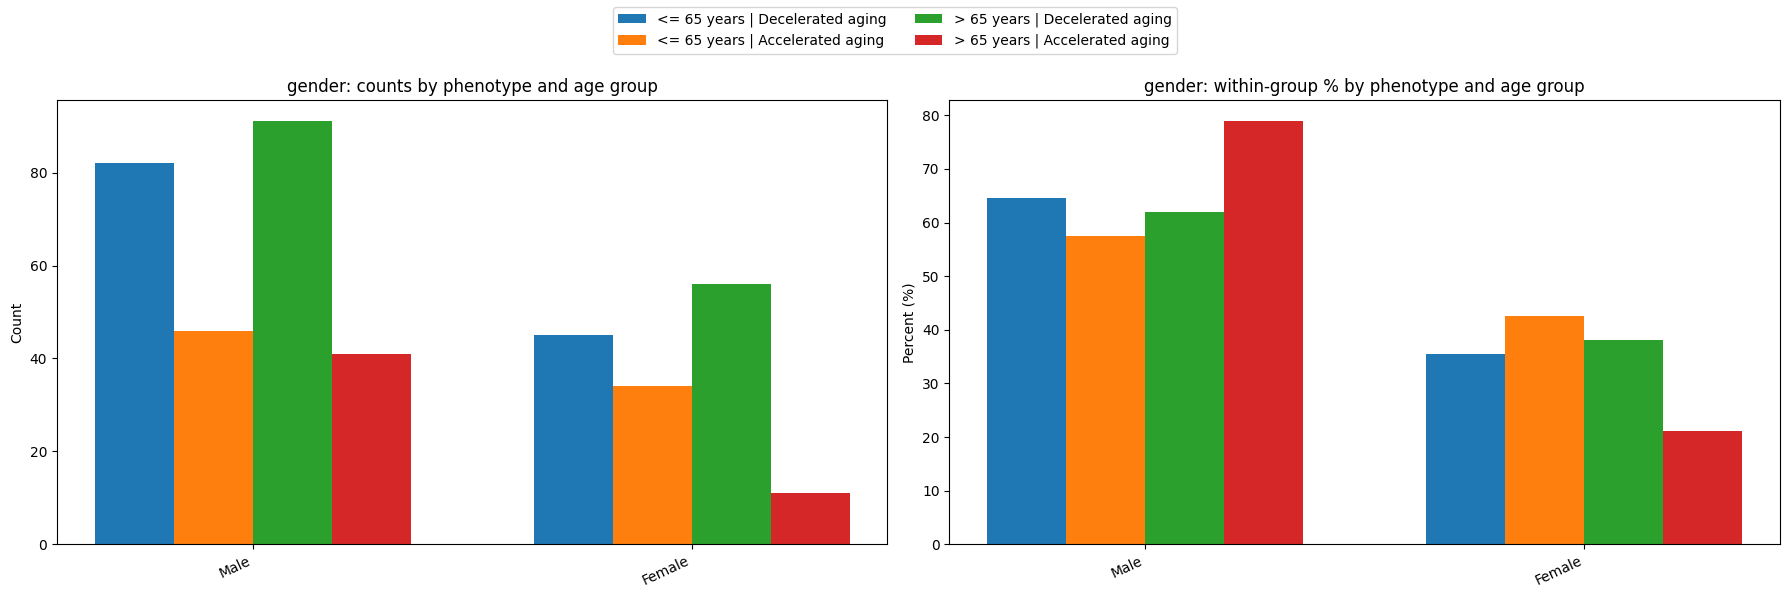

[DONE] gender
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\gender_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\gender_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\gender_agegroup_x_phenotype_1x2.png


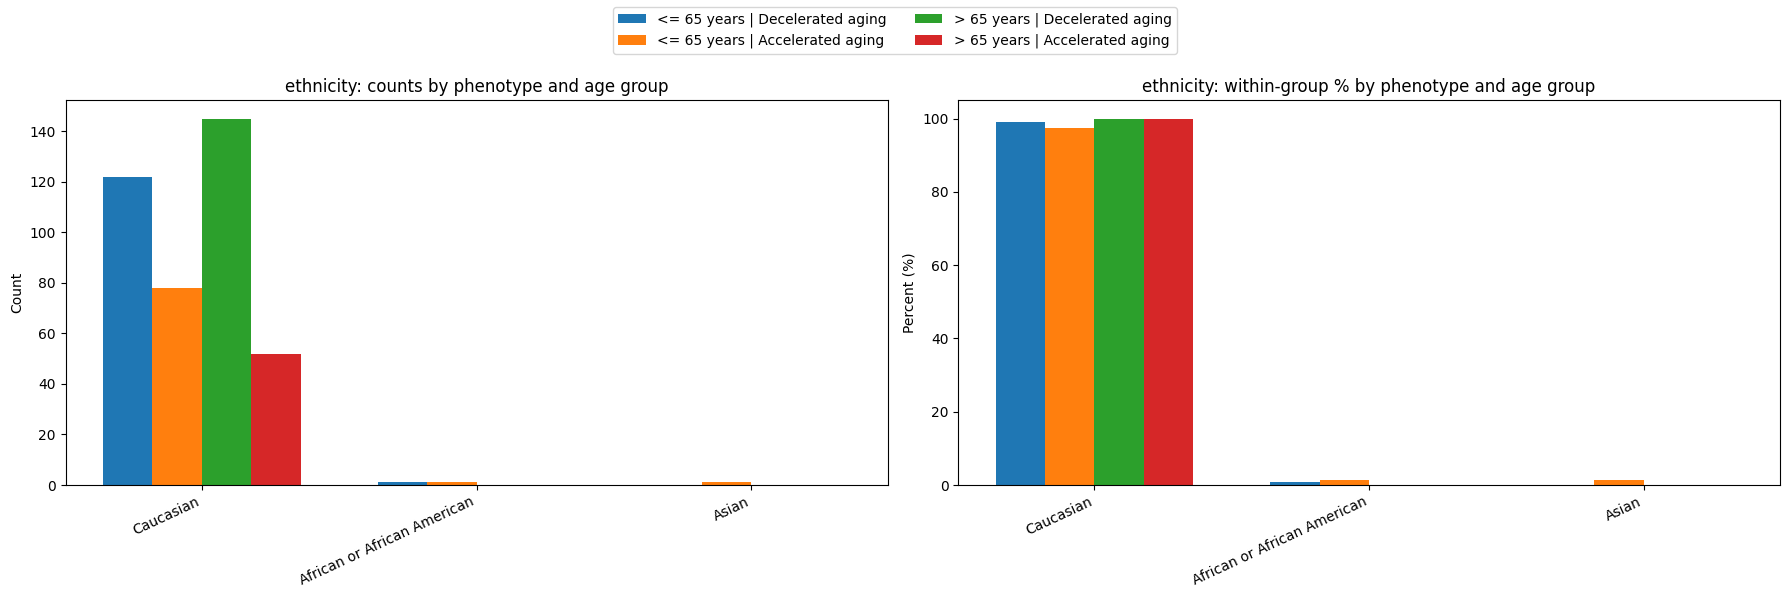

[DONE] ethnicity
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\ethnicity_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\ethnicity_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\ethnicity_agegroup_x_phenotype_1x2.png


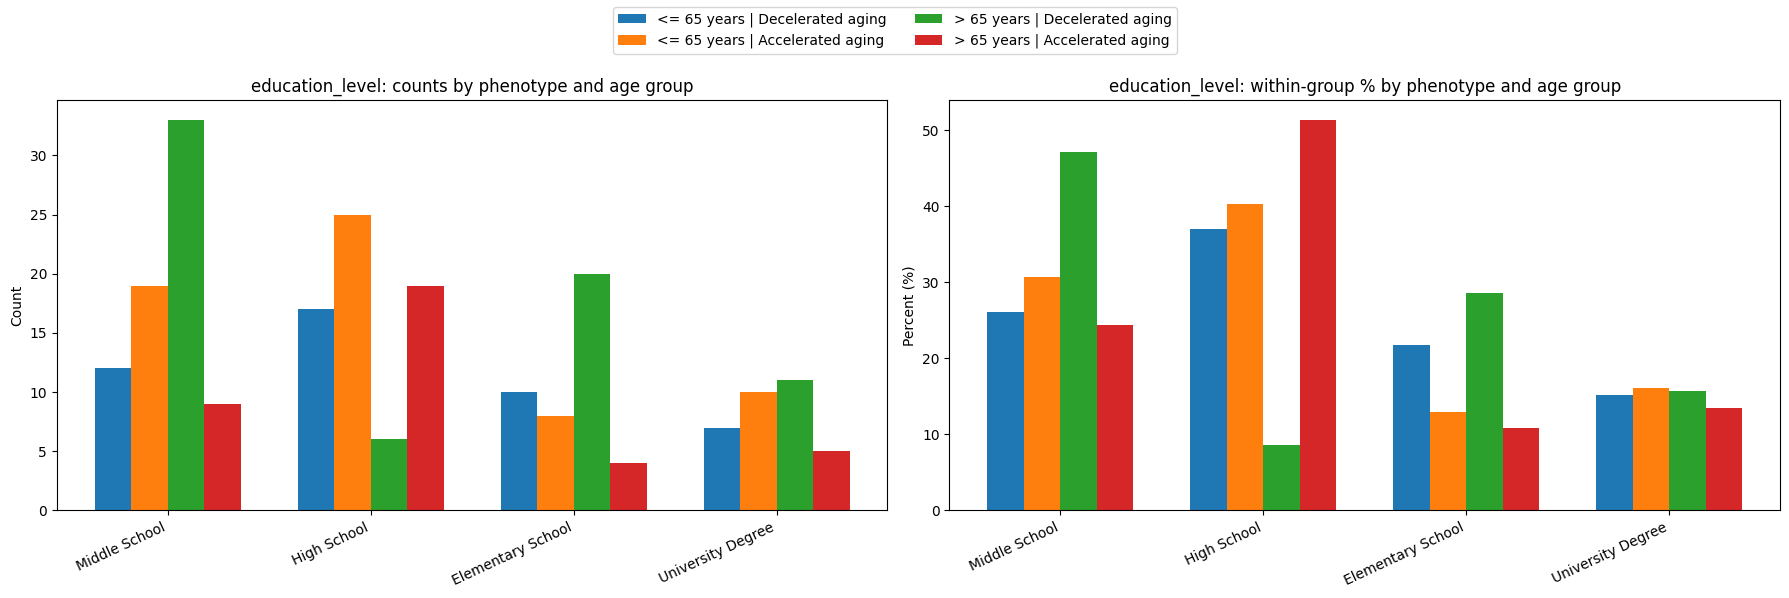

[DONE] education_level
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\education_level_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\education_level_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\education_level_agegroup_x_phenotype_1x2.png


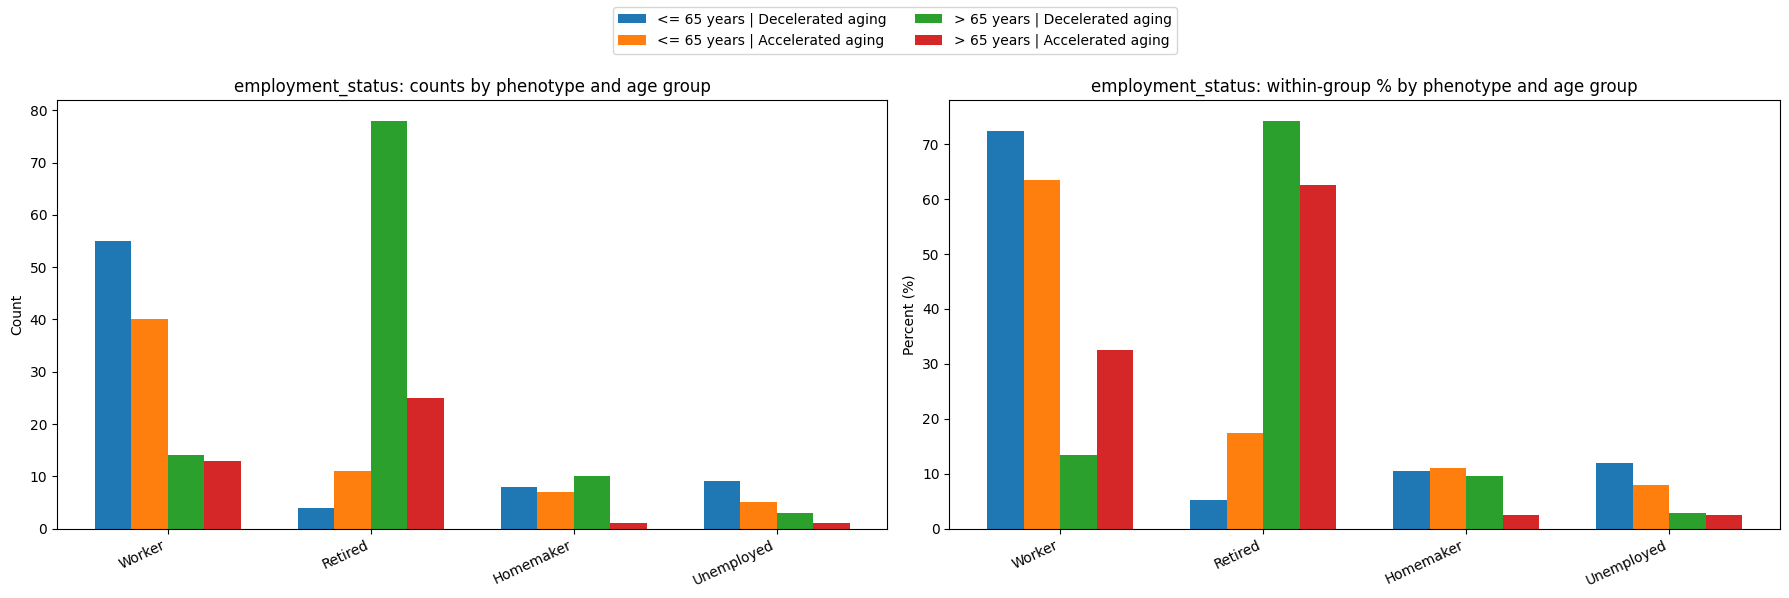

[DONE] employment_status
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\employment_status_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\employment_status_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\employment_status_agegroup_x_phenotype_1x2.png


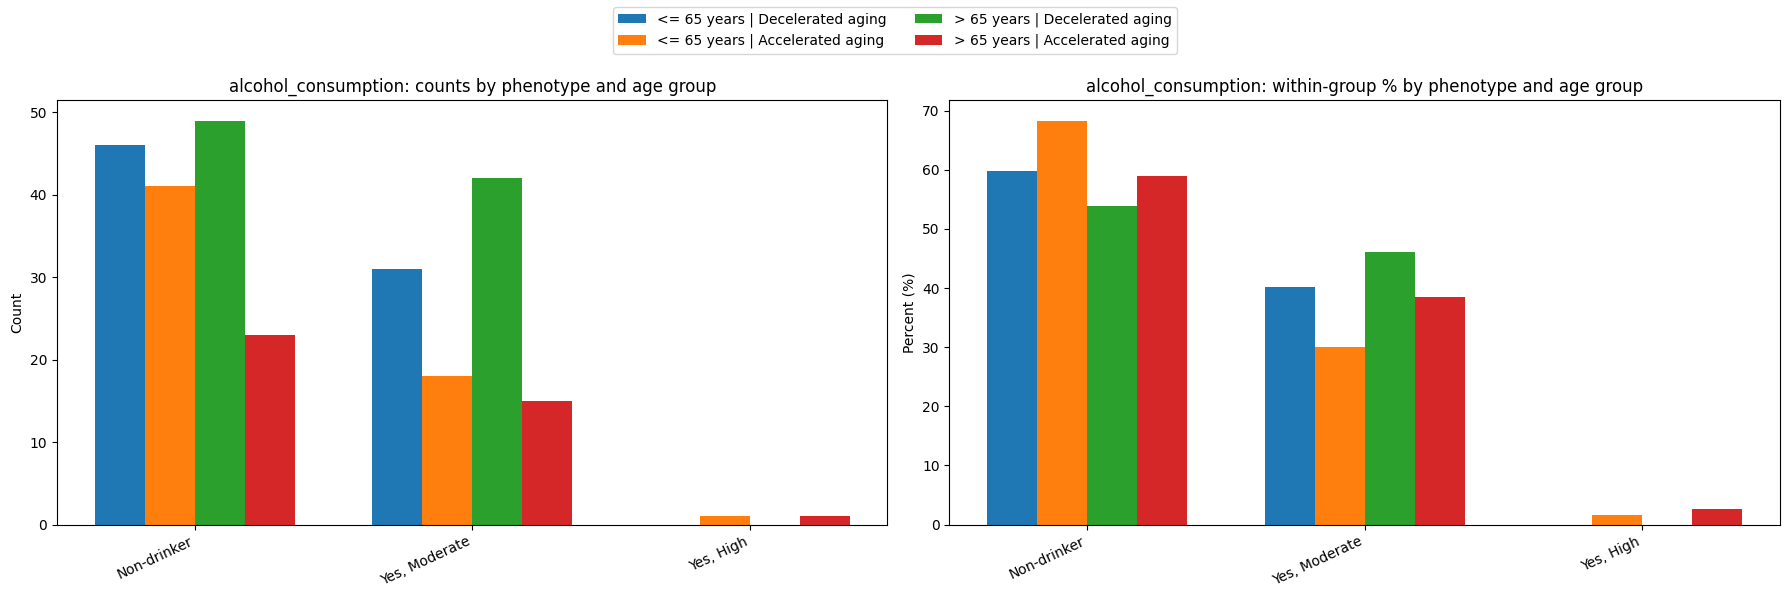

[DONE] alcohol_consumption
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\alcohol_consumption_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\alcohol_consumption_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\alcohol_consumption_agegroup_x_phenotype_1x2.png


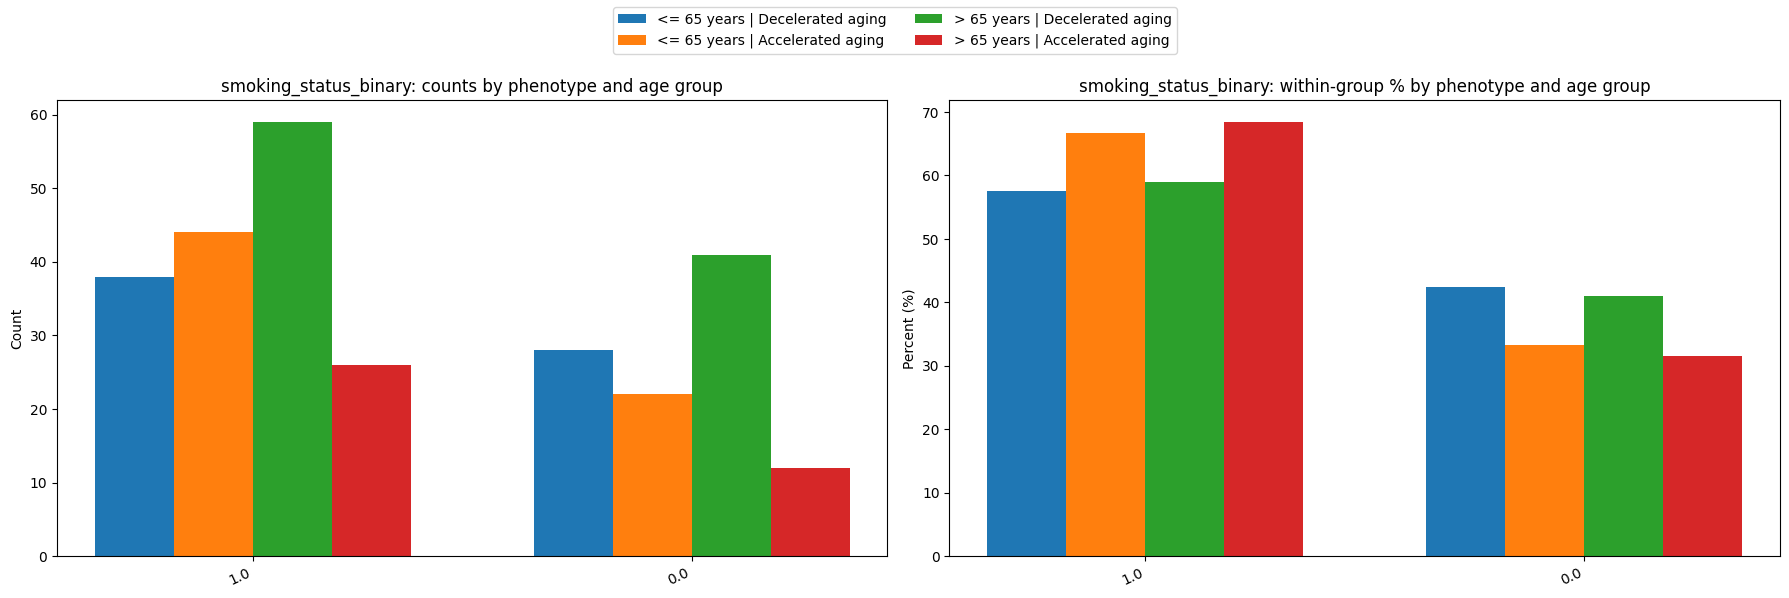

[DONE] smoking_status_binary
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\smoking_status_binary_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\smoking_status_binary_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\smoking_status_binary_agegroup_x_phenotype_1x2.png


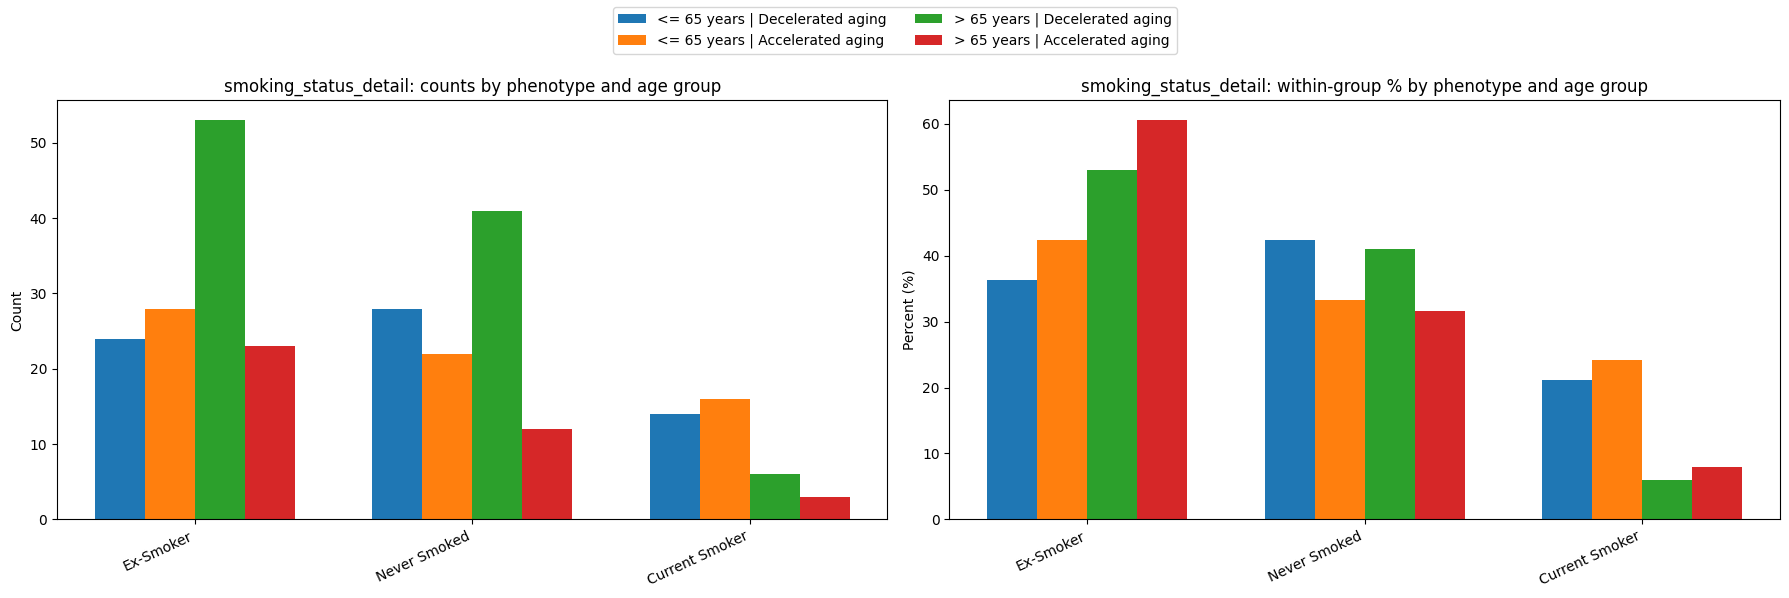

[DONE] smoking_status_detail
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\smoking_status_detail_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\smoking_status_detail_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\smoking_status_detail_agegroup_x_phenotype_1x2.png


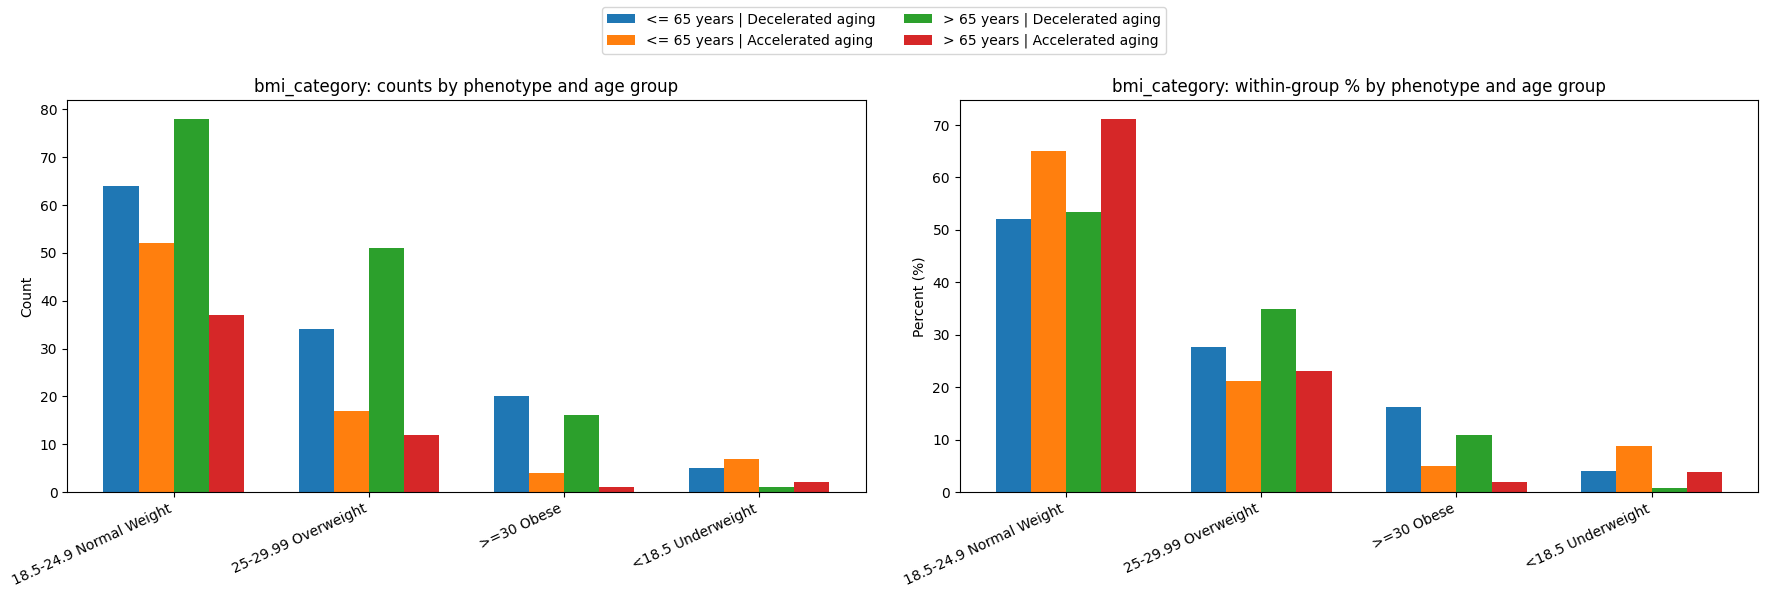

[DONE] bmi_category
  Saved:
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\bmi_category_tidy.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables\bmi_category_wide.csv
   - C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots\bmi_category_agegroup_x_phenotype_1x2.png

All socio-economic descriptives completed.
Tables saved in: C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\tables
Plots saved in: C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\plots


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) Paths (EDIT)
# ----------------------------
DATA_PATH = r"C:\Users\HP\OneDrive\Desktop\Phase 3\merged_with_phenotypes\master_with_phenotype.csv"
OUT_DIR   = r"C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype"

os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# 1) Helpers
# ----------------------------
def is_missing_like(x) -> bool:
    if pd.isna(x):
        return True
    s = str(x).strip().lower()
    # common "missing" patterns
    bad = {
        "", "na", "n/a", "none", "null", "missing", "unknown", "missing/unknown",
        "not known", "not available", "nan"
    }
    if s in bad:
        return True
    if ("missing" in s) or ("unknown" in s) or ("not available" in s):
        return True
    return False

def safe_name(s: str) -> str:
    s = str(s).strip()
    s = re.sub(r"[<>:\"/\\|?*]", "_", s)  # windows invalid
    s = re.sub(r"\s+", "_", s)
    return s

def clean_category_series(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    s = s[~s.apply(is_missing_like)]
    return s

# ----------------------------
# 2) Load + core cleaning
# ----------------------------
df = pd.read_csv(DATA_PATH)
df.columns = [str(c).strip() for c in df.columns]

required = ["phenotype", "age_group"]
for c in required:
    if c not in df.columns:
        raise ValueError(f"Missing required column '{c}'. Columns: {df.columns.tolist()}")

# Age groups: keep only these two
age_order = ["<= 65 years", "> 65 years"]
df["age_group_clean"] = df["age_group"].astype(str).str.strip()
df = df[~df["age_group_clean"].apply(is_missing_like)].copy()
df = df[df["age_group_clean"].isin(age_order)].copy()

# Phenotype clean
df["phenotype"] = pd.to_numeric(df["phenotype"], errors="coerce")
df = df[df["phenotype"].isin([0, 1])].copy()

PHENO_LABEL = {0: "Decelerated aging", 1: "Accelerated aging"}
df["phenotype_label"] = df["phenotype"].map(PHENO_LABEL)

print("Rows after core cleaning:", len(df))
print("Age groups:", sorted(df["age_group_clean"].unique().tolist()))
print("Phenotypes:", df["phenotype"].value_counts().to_dict())

# ----------------------------
# 3) Socio-economic variables to run
#    (EDIT this list if you want)
# ----------------------------
SOCIO_ECON_VARS = [
    "gender",
    "ethnicity",
    "education_level",
    "employment_status",
    "alcohol_consumption",
    "smoking_status_binary",
    "smoking_status_detail",
    "bmi_category"
]

SOCIO_ECON_VARS = [v for v in SOCIO_ECON_VARS if v in df.columns]
if not SOCIO_ECON_VARS:
    raise ValueError("None of the socio-economic variables were found in the dataset.")

# Output folders
TABLE_DIR = os.path.join(OUT_DIR, "tables")
PLOT_DIR  = os.path.join(OUT_DIR, "plots")
os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# ----------------------------
# 4) Main function for a categorical variable
# ----------------------------
def summarize_categorical(var: str, top_k: int = None):
    """
    Produces:
      - tidy table: counts and within-age-group % by phenotype
      - wide table: easier to read in Excel
      - 1x2 plot: counts and % in a single figure
    """
    work = df[["age_group_clean", "phenotype_label", var]].copy()

    # remove missing/unknown categories
    work[var] = work[var].astype(str).str.strip()
    work = work[~work[var].apply(is_missing_like)].copy()

    if len(work) == 0:
        print(f"[SKIP] {var}: no rows after removing missing/unknown.")
        return

    # Optionally restrict to top_k categories (useful when categories explode)
    if top_k is not None:
        top = work[var].value_counts().head(top_k).index.tolist()
        work = work[work[var].isin(top)].copy()

    # Counts
    counts = (
        work
        .groupby(["age_group_clean", "phenotype_label", var], dropna=False)
        .size()
        .reset_index(name="n")
    )

    # Denominators per (age_group, phenotype)
    denom = (
        work
        .groupby(["age_group_clean", "phenotype_label"])
        .size()
        .reset_index(name="denom")
    )

    tidy = counts.merge(denom, on=["age_group_clean", "phenotype_label"], how="left")
    tidy["percent"] = (tidy["n"] / tidy["denom"]) * 100

    # Save tidy
    tidy_path = os.path.join(TABLE_DIR, f"{safe_name(var)}_tidy.csv")
    tidy.to_csv(tidy_path, index=False)

    # Wide table (counts)
    wide_n = tidy.pivot_table(
        index=[var],
        columns=["age_group_clean", "phenotype_label"],
        values="n",
        aggfunc="sum",
        fill_value=0
    )
    wide_n.columns = [f"n_{ag}_{ph}" for ag, ph in wide_n.columns]
    wide_n = wide_n.reset_index()

    # Wide table (percents)
    wide_p = tidy.pivot_table(
        index=[var],
        columns=["age_group_clean", "phenotype_label"],
        values="percent",
        aggfunc="mean"
    )
    wide_p.columns = [f"pct_{ag}_{ph}" for ag, ph in wide_p.columns]
    wide_p = wide_p.reset_index()

    # Merge wide outputs
    wide = wide_n.merge(wide_p, on=var, how="left")

    wide_path = os.path.join(TABLE_DIR, f"{safe_name(var)}_wide.csv")
    wide.to_csv(wide_path, index=False)

    # ----------------------------
    # Plot prep
    # ----------------------------
    # Order categories by total frequency (stable ordering)
    cat_order = (
        work[var]
        .value_counts()
        .index
        .tolist()
    )

    # Build a matrix for plotting counts and percents
    plot_rows = []
    for ag in age_order:
        for ph in [PHENO_LABEL[0], PHENO_LABEL[1]]:
            sub = tidy[(tidy["age_group_clean"] == ag) & (tidy["phenotype_label"] == ph)].copy()
            # ensure all categories exist
            for cat in cat_order:
                r = sub[sub[var] == cat]
                if len(r) == 0:
                    plot_rows.append({"age_group": ag, "phenotype": ph, "category": cat, "n": 0, "percent": 0.0})
                else:
                    plot_rows.append({
                        "age_group": ag,
                        "phenotype": ph,
                        "category": cat,
                        "n": int(r["n"].values[0]),
                        "percent": float(r["percent"].values[0])
                    })

    plot_df = pd.DataFrame(plot_rows)

    # ----------------------------
    # 1x2 Plot: counts + percent
    # ----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    x = np.arange(len(cat_order))
    width = 0.18  # bar width

    # We want 4 bars per category:
    # <=65 Decel, <=65 Accel, >65 Decel, >65 Accel
    combos = [
        ("<= 65 years", PHENO_LABEL[0], -1.5*width),
        ("<= 65 years", PHENO_LABEL[1], -0.5*width),
        ("> 65 years",  PHENO_LABEL[0],  0.5*width),
        ("> 65 years",  PHENO_LABEL[1],  1.5*width),
    ]

    # (A) Counts
    for ag, ph, off in combos:
        y = [
            plot_df[(plot_df.age_group == ag) & (plot_df.phenotype == ph) & (plot_df.category == cat)]["n"].values[0]
            for cat in cat_order
        ]
        axes[0].bar(x + off, y, width, label=f"{ag} | {ph}")

    axes[0].set_title(f"{var}: counts by phenotype and age group")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(cat_order, rotation=25, ha="right")
    axes[0].set_ylabel("Count")

    # (B) Percent
    for ag, ph, off in combos:
        y = [
            plot_df[(plot_df.age_group == ag) & (plot_df.phenotype == ph) & (plot_df.category == cat)]["percent"].values[0]
            for cat in cat_order
        ]
        axes[1].bar(x + off, y, width, label=f"{ag} | {ph}")

    axes[1].set_title(f"{var}: within-group % by phenotype and age group")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(cat_order, rotation=25, ha="right")
    axes[1].set_ylabel("Percent (%)")

    # One legend for the whole figure
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=True)

    plt.tight_layout(rect=[0, 0, 1, 0.90])

    fig_path = os.path.join(PLOT_DIR, f"{safe_name(var)}_agegroup_x_phenotype_1x2.png")
    plt.savefig(fig_path, dpi=200)
    plt.show()

    print(f"[DONE] {var}")
    print("  Saved:")
    print("   -", tidy_path)
    print("   -", wide_path)
    print("   -", fig_path)

# ----------------------------
# 5) Run all socio-economic variables
# ----------------------------
for v in SOCIO_ECON_VARS:
    summarize_categorical(v, top_k=None)  # set top_k=10 if a variable has too many categories

print("\nAll socio-economic descriptives completed.")
print("Tables saved in:", TABLE_DIR)
print("Plots saved in:", PLOT_DIR)


In [3]:
import os
import re
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from scipy.stats import chi2

# ----------------------------
# PATHS (EDIT)
# ----------------------------
DATA_PATH = r"C:\Users\HP\OneDrive\Desktop\Phase 3\merged_with_phenotypes\death_with_phenotype.csv"
OUT_DIR   = r"C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# CONSTANTS (DO NOT CHANGE LABELS)
# ----------------------------
AGE_COL = "age_group"
PHENO_COL = "phenotype"

AGE_ALLOWED = ["<= 65 years", "> 65 years"]  # exact labels
SOCIO_CAT_VARS = [
    "alcohol_consumption",
    "bmi_category",
    "education_level",
    "employment_status",
    "ethnicity",
    "gender",
    "smoking_status_detail"
]

# Optional: clinician-facing labels (doesn't affect tests)
PHENO_LABEL = {
    0: "Decelerated Aging (Resilient)",
    1: "Accelerated Aging (Frailty)"
}

# ----------------------------
# HELPERS
# ----------------------------
EXCLUDE_RE = re.compile(r"(missing|unknown|not\s*known|not\s*noted|n/?a|null|none)", flags=re.IGNORECASE)

def is_missing_like(x) -> bool:
    if pd.isna(x):
        return True
    s = str(x).strip()
    if s == "":
        return True
    return bool(EXCLUDE_RE.search(s))

def clean_cat(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    # Keep original wording but strip whitespace; missing handled separately
    return s

def lr_test(full_res, red_res):
    lr_stat = 2 * (full_res.llf - red_res.llf)
    df_diff = int(full_res.df_model - red_res.df_model)
    p_val = float(chi2.sf(lr_stat, df_diff)) if df_diff > 0 else np.nan
    return float(lr_stat), df_diff, p_val

# ----------------------------
# LOAD + CLEAN CORE
# ----------------------------
df = pd.read_csv(DATA_PATH)
df.columns = [str(c).strip() for c in df.columns]

needed = {AGE_COL, PHENO_COL}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Available: {df.columns.tolist()}")

# strict age labels
df["age_group_clean"] = df[AGE_COL].astype(str).str.strip()
df = df[df["age_group_clean"].isin(AGE_ALLOWED)].copy()

# phenotype must be 0/1
df[PHENO_COL] = pd.to_numeric(df[PHENO_COL], errors="coerce")
df = df[df[PHENO_COL].isin([0, 1])].copy()
df[PHENO_COL] = df[PHENO_COL].astype(int)

# Add phenotype label column (optional)
df["phenotype_label"] = df[PHENO_COL].map(PHENO_LABEL)

print("Rows after core cleaning:", len(df))
print("Age groups:", df["age_group_clean"].value_counts().to_dict())
print("Phenotypes:", df[PHENO_COL].value_counts().to_dict())

# ----------------------------
# 1) DESCRIPTIVES (age_group x phenotype x level) FOR EACH SOCIO VAR
# ----------------------------
desc_all = []
for var in SOCIO_CAT_VARS:
    if var not in df.columns:
        continue

    tmp = df[["age_group_clean", PHENO_COL, "phenotype_label", var]].copy()
    tmp[var] = clean_cat(tmp[var])
    tmp = tmp[~tmp[var].apply(is_missing_like)].copy()

    if tmp.empty:
        continue

    tab = (
        tmp
        .groupby(["age_group_clean", "phenotype_label", var])
        .size()
        .reset_index(name="count")
    )

    # Within each age_group, phenotype: percent across levels
    tab["percent_within_age_pheno"] = tab.groupby(["age_group_clean", "phenotype_label"])["count"].transform(
        lambda x: 100 * x / x.sum()
    )

    tab["variable"] = var
    tab = tab.rename(columns={var: "level"})
    desc_all.append(tab)

desc_df = pd.concat(desc_all, ignore_index=True) if desc_all else pd.DataFrame()
desc_path = os.path.join(OUT_DIR, "phase4_socioeconomic_descriptives.csv")
desc_df.to_csv(desc_path, index=False)
print("Saved descriptives:", desc_path)

# ----------------------------
# 2) ONE 3D TEST PER VARIABLE (LRT ~ chi-square)
#    Reduced: phenotype ~ age_group
#    Full:    phenotype ~ age_group * variable
# ----------------------------
test_rows = []

for var in SOCIO_CAT_VARS:
    if var not in df.columns:
        continue

    tmp = df[["age_group_clean", PHENO_COL, var]].copy()
    tmp[var] = clean_cat(tmp[var])

    # Drop missing-like levels
    tmp = tmp[~tmp[var].apply(is_missing_like)].copy()

    # Need at least 2 levels for the variable
    n_levels = tmp[var].nunique(dropna=True)
    if n_levels < 2 or len(tmp) < 10:
        test_rows.append({
            "variable": var,
            "n_total_used": len(tmp),
            "n_levels": int(n_levels),
            "lr_chi2": np.nan,
            "df": np.nan,
            "p_value": np.nan,
            "note": "Skipped: insufficient levels or sample size"
        })
        continue

    # Ensure variable is treated as categorical
    tmp[var] = tmp[var].astype("category")

    # Fit reduced and full binomial GLM
    # phenotype is 0/1 => Binomial + logit
    try:
        red = smf.glm(f"{PHENO_COL} ~ C(age_group_clean)", data=tmp, family=Binomial()).fit()
        full = smf.glm(f"{PHENO_COL} ~ C(age_group_clean) * C({var})", data=tmp, family=Binomial()).fit()

        lr_chi2, df_diff, p_val = lr_test(full, red)

        test_rows.append({
            "variable": var,
            "n_total_used": int(len(tmp)),
            "n_levels": int(n_levels),
            "lr_chi2": lr_chi2,
            "df": df_diff,
            "p_value": p_val,
            "note": "OK"
        })

    except Exception as e:
        test_rows.append({
            "variable": var,
            "n_total_used": int(len(tmp)),
            "n_levels": int(n_levels),
            "lr_chi2": np.nan,
            "df": np.nan,
            "p_value": np.nan,
            "note": f"Model failed: {type(e).__name__}"
        })

tests_df = pd.DataFrame(test_rows)
tests_path = os.path.join(OUT_DIR, "phase4_socioeconomic_3way_LRtests.csv")
tests_df.to_csv(tests_path, index=False)

print("Saved 3-way tests:", tests_path)
print(tests_df.sort_values("p_value", na_position="last"))


Rows after core cleaning: 406
Age groups: {'<= 65 years': 207, '> 65 years': 199}
Phenotypes: {0: 274, 1: 132}
Saved descriptives: C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\phase4_socioeconomic_descriptives.csv
Saved 3-way tests: C:\Users\HP\OneDrive\Desktop\Phase 4\descriptives_agegroup_x_phenotype\phase4_socioeconomic_3way_LRtests.csv
                variable  n_total_used  n_levels    lr_chi2  df   p_value note
2        education_level           215         4  26.790984   6  0.000158   OK
1           bmi_category           406         4  19.720208   6  0.003105   OK
3      employment_status           289         4  13.681981   6  0.033398   OK
5                 gender           406         2   6.247095   2  0.044001   OK
0    alcohol_consumption           272         3   5.489817   4  0.240626   OK
4              ethnicity           405         3   2.019349   2  0.364338   OK
6  smoking_status_detail           270         3   2.249279   4  0.690018   OK


In [5]:
# --------------------------------------------------
# 1) Load VERO scores WITH patient_id
# --------------------------------------------------
vero_path = r"C:\Users\HP\OneDrive\Desktop\Phase 5\phase5_outputs/phase5_vero_scores_all_patients_WITH_patient_id.csv"
vero = pd.read_csv(vero_path)

required_cols = {"patient_id", "vero_index_0_100"}
if not required_cols.issubset(vero.columns):
    raise ValueError(f"Missing required columns: {required_cols}")

# --------------------------------------------------
# 2) Define risk strata
# --------------------------------------------------
def risk_stratum(score):
    if score <= 30:
        return "Low Risk (0–30)"
    elif score <= 70:
        return "Medium Risk (31–70)"
    else:
        return "High Risk (71–100)"

vero["risk_stratum"] = vero["vero_index_0_100"].apply(risk_stratum)

# --------------------------------------------------
# 3) Compute distribution summary
# --------------------------------------------------
summary = (
    vero
    .groupby("risk_stratum")
    .agg(
        n_patients=("patient_id", "count"),
        mean_score=("vero_index_0_100", "mean"),
        median_score=("vero_index_0_100", "median"),
        q1=("vero_index_0_100", lambda x: x.quantile(0.25)),
        q3=("vero_index_0_100", lambda x: x.quantile(0.75)),
        min_score=("vero_index_0_100", "min"),
        max_score=("vero_index_0_100", "max"),
    )
    .reset_index()
)

# Percent of cohort
summary["percent_of_cohort"] = (
    100 * summary["n_patients"] / summary["n_patients"].sum()
).round(1)

# Order strata logically
order = ["Low Risk (0–30)", "Medium Risk (31–70)", "High Risk (71–100)"]
summary["risk_stratum"] = pd.Categorical(summary["risk_stratum"], order)
summary = summary.sort_values("risk_stratum")

# --------------------------------------------------
# 4) Save summary table
# --------------------------------------------------
summary.to_csv(r"C:\Users\HP\OneDrive\Desktop\Phase 5\phase5_outputs\phase5_vero_score_distribution_summary.csv", index=False)

print("Saved: phase5_vero_score_distribution_summary.csv")
print(summary)


Saved: phase5_vero_score_distribution_summary.csv
          risk_stratum  n_patients  mean_score  median_score     q1     q3  \
1      Low Risk (0–30)         239    9.154812           5.0   1.00   17.0   
2  Medium Risk (31–70)          83   43.927711          41.0  36.50   50.0   
0   High Risk (71–100)          84   90.309524          93.0  83.75  100.0   

   min_score  max_score  percent_of_cohort  
1          0         30               58.9  
2         32         69               20.4  
0         72        100               20.7  
